# Varying GAN hyperparameters

We analyse results of experiments training real GANs (DCGAN) on CIFAR10 for various choices of the noise variance parameter $\sigma_z$ and $\kappa$.

Experiments are conducted outside the notebook using the `gan.py` script. 

In [173]:
from collections import defaultdict
import os
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [313]:
results_loc = "/work/jr19127/gan-loss-surfaces/rmt_results/vary_sigma"
result_fns = sorted(os.listdir(results_loc), key=lambda s: int(s.split("_")[1]))
rmt_results = []
for fn in result_fns:
    with open(os.path.join(results_loc, fn), "rb") as fin:
        rmt_results.append([x if x is not None else np.nan for x in pkl.load(fin)])
rmt_results = np.array(rmt_results)

sigmas = rmt_results[:, 0]
min_uDs = rmt_results[:, 1]
min_uGs = rmt_results[:, 2]
min_sums = rmt_results[:, 3]

In [310]:
results_dir = "/work/jr19127/gan-loss-surfaces/vary_sigma_dcgan_cifar10"
results_dirs  = [os.path.join(results_dir, "results_{}".format(ind)) 
                 for ind in range(len(os.listdir(results_dir)))][:-1]
pkl_files = [os.path.join(rdir, x) for rdir in results_dirs for x in os.listdir(rdir) if x[-3:]==".pk"]

results = defaultdict(list)
for fn in pkl_files:
    with open(os.path.join(results_dir, fn), "rb") as fin:
        results[float(fn.split("/")[-1][:-3])].append(np.array(pkl.load(fin)))

In [324]:
def summary(arr):
#     return min(arr[-100:])
#     return min(arr)
#     return arr[.-1]
    return np.min(pd.Series(arr).rolling(500).mean().dropna().values)


discrims = np.array([np.mean([summary(r[0]) for r in results[s]]) for s in sigmas])
discrims_std = np.array([np.std([summary(r[0]) for r in results[s]]) for s in sigmas])

gens = np.array([np.mean([summary(r[1]) for r in results[s]]) for s in sigmas])
gens_std = np.array([np.std([summary(r[1]) for r in results[s]]) for s in sigmas])

boths = np.array([np.mean([summary(r[0]+r[1]) for r in results[s]]) for s in sigmas])
boths_std = np.array([np.std([summary(r[0] + r[1]) for r in results[s]]) for s in sigmas])


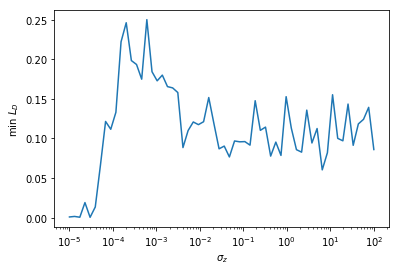

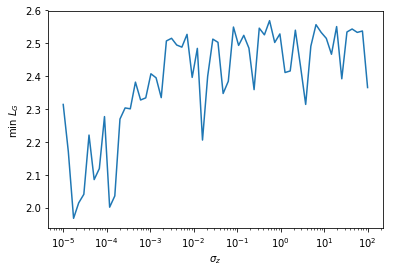

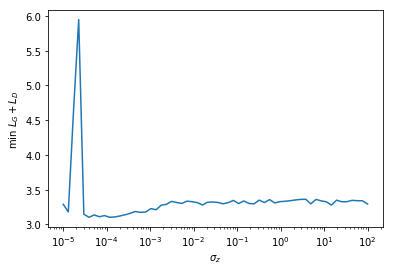

In [325]:
plt.plot(sigmas, discrims);
# plt.fill_between(sigmas, discrims-1.96*discrims_std, discrims+1.96*discrims_std, alpha=0.2);
plt.xlabel("$\sigma_z$");
plt.ylabel("min $L_D$");
plt.xscale('log')

onfrom = 0
plt.savefig("figures/ld_cifar10_gan.pdf")
plt.show();

plt.plot(sigmas[onfrom:], gens[onfrom:]);
# plt.fill_between(sigmas[onfrom:], gens[onfrom:]-1*gens_std[onfrom:], gens[onfrom:]+1*gens_std[onfrom:], 
#                  alpha=0.2);
plt.xlabel("$\sigma_z$");
plt.ylabel("min $L_G$");
plt.xscale('log')
plt.savefig("figures/lg_cifar10_gan.pdf")

plt.show();
plt.plot(sigmas, boths);
# plt.fill_between(sigmas, boths-1.96*boths_std, boths+1.96*boths_std, alpha=0.2);
plt.xlabel("$\sigma_z$");
plt.ylabel("min $L_G + L_D$");
plt.xscale('log')
plt.savefig("figures/ldlg_cifar10_gan.pdf")


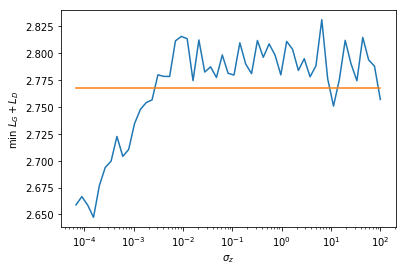

In [323]:
# plt.plot(sigmas, discrims);
# plt.xlabel("$\sigma_z$");
# plt.ylabel("min $L_D$");
# plt.xscale('log')

# onfrom = 0
# plt.savefig("figures/ld_cifar10_gan.pdf")
# plt.show();

# plt.plot(sigmas[onfrom:], gens[onfrom:]);

# plt.xlabel("$\sigma_z$");
# plt.ylabel("min $L_G$");
# plt.xscale('log')
# plt.savefig("figures/lg_cifar10_gan.pd

n_nan = ~np.isnan(min_sums)
possible_sigmas = sigma_zs[~np.isnan(min_sums)]
min_sigma  = possible_sigmas[0]
plot_gens = boths[sigmas >= min_sigma]
plot_mins = min_sums[n_nan]

from scipy.optimize import minimize

def loss(args, data, theory):
    not_nan = ~np.isnan(theory)
    a, b = args
    trans = theory[not_nan]*b + a
    diff = trans - data[-np.sum(not_nan):]
    return np.sum(diff**2)

args = minimize(loss, (0, 1), (plot_gens, plot_mins), bounds=[(0, None), (0, None)]).x
a, b = args

plt.show();
plt.plot(sigma_zs[n_nan], plot_gens);
plt.plot(sigma_zs[n_nan], plot_mins*b + a);
plt.xlabel("$\sigma_z$");
plt.ylabel("min $L_G + L_D$");
plt.xscale('log')


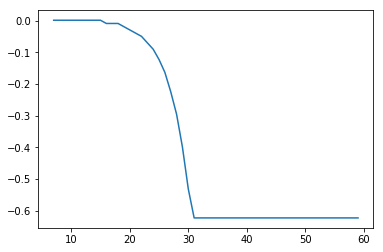

In [319]:
plt.plot(min_uGs)

In [260]:
possible_sigmas = sigma_zs[~np.isnan(min_sums)]

In [261]:
min_theoretical_sigma = possible_sigmas[0]

In [257]:
def get_loss(ind=None, sigma=None):
    if ind is not None:
        sigma = sorted(list(results.keys()))[ind]
    discrims = pd.DataFrame(np.array([r[0] for r in results[sigma]]).T).values
    gens = pd.DataFrame(np.array([r[1] for r in results[sigma]]).T).values
    return discrims.T, gens.T

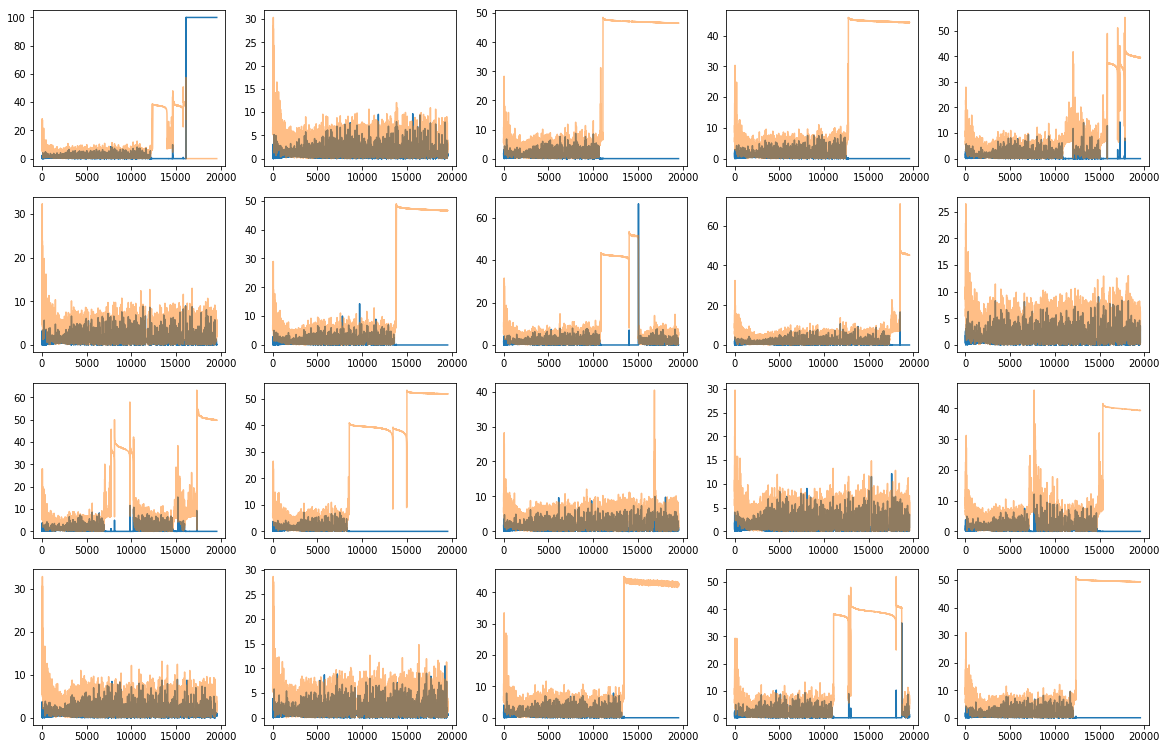

In [259]:
d, g = get_loss(sigma=min_theoretical_sigma)
plt.figure(figsize=(20,20))
for i in range(len(d)):
    plt.subplot(6, 5, i+1)
    plt.plot(d[i]);
    plt.plot(g[i], alpha=0.5);

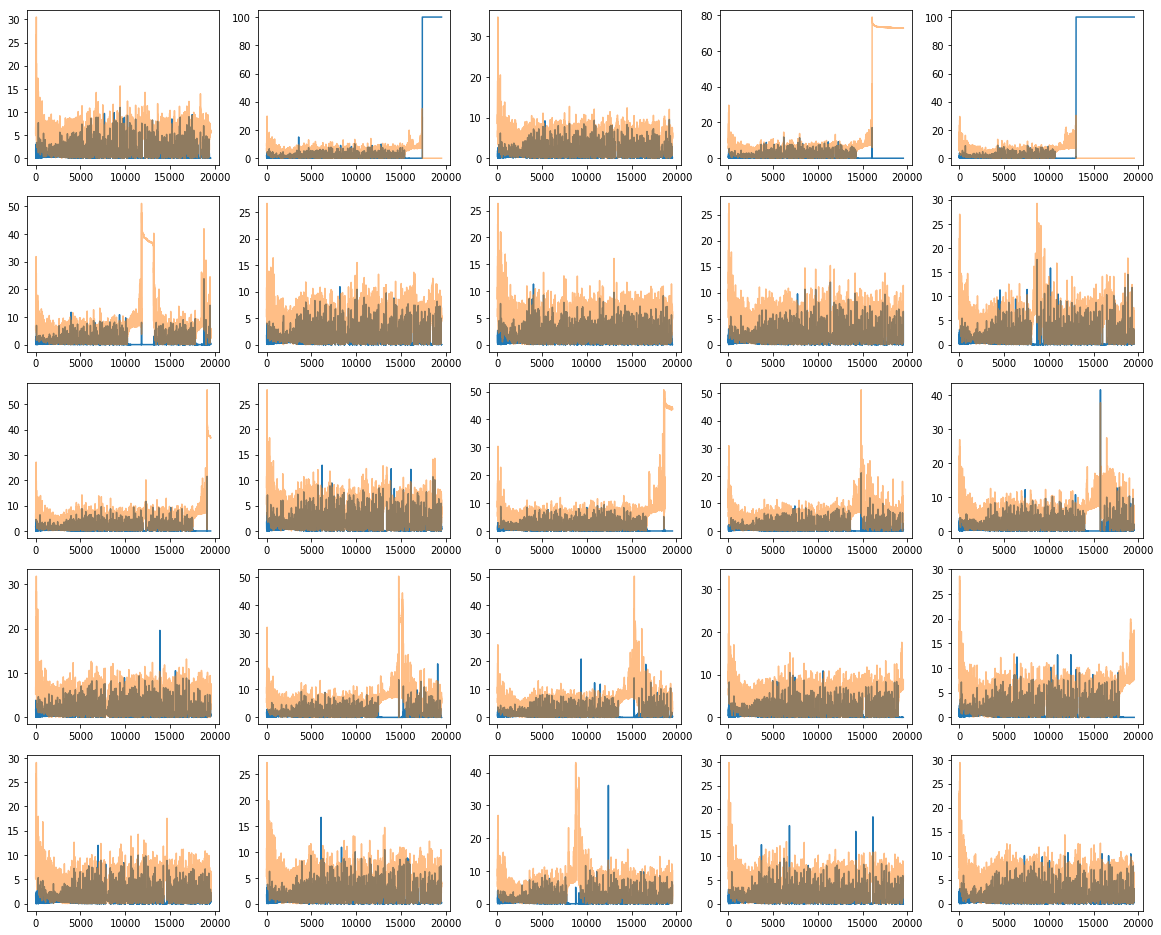

In [265]:
d, g = get_loss(sigma=possible_sigmas[-1])
plt.figure(figsize=(20,20))
for i in range(len(d)):
    plt.subplot(6, 5, i+1)
    plt.plot(d[i]);
    plt.plot(g[i], alpha=0.5);

In [281]:
max_diffs = []
for i in range(len(sigmas)):
    d, g = get_loss(ind=i)
    d = pd.DataFrame(d.T).rolling(100).mean().dropna(axis=0).values.T
    g = pd.DataFrame(g.T).rolling(100).mean().dropna(axis=0).values.T
    diff = np.abs(d-g)
    max_diff = np.max(diff, axis=1)
    max_diffs.append(np.mean(max_diff))


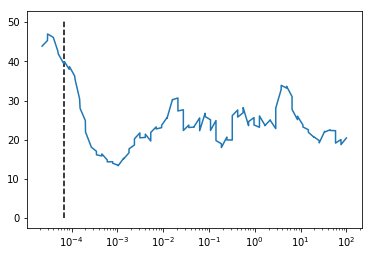

In [283]:
plt.plot(sigmas, pd.Series(max_diffs).rolling(5).mean().values);
plt.vlines([min_theoretical_sigma], [0], np.max(max_diffs), linestyles='--', color='k');
plt.xscale('log')

In [275]:
d, g = get_loss(ind=i)
d = pd.DataFrame(d.T).rolling(50).mean().dropna(axis=0).values.T
g = pd.DataFrame(g.T).rolling(50).mean().dropna(axis=0).values.T

In [276]:
d.shape

(25, 19501)